In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import h5py
import time
from keras.models import load_model
np.random.seed(21)

Using TensorFlow backend.


In [2]:
# load data with datetime index
power_data = pd.read_csv('../data/Power grid/Daily/data.csv', parse_dates=[0])

# sort by date
power_data.sort_values('Date', inplace=True)

# reindex dataframe
power_data.set_index(keys=['Date'], drop=True, inplace=True)
print('='*40)

# check for missing values
print(power_data.isnull().sum())
print('='*40)

# convert 'Change %' column entries to numbers
power_data['Change %'] = power_data['Change %'].apply(lambda x:float(x.split('%')[0]))

def convert(row):
    '''Function for converting volume entries to numbers
    Input: row ---> Row entry; for ex: 5.1M, 8.22K
    Output num ---> Volume in numbers; for ex: 5.1M to 5100000  
    '''
    if row[-1] == 'M':
        num = float(row[:-1])*1000000
    elif row[-1] == 'K':
        num = float(row[:-1])*1000
    elif row[-1] == '-':
        num = 0
    return num

# convert 'Vol.' column entries to numbers
power_data['Vol.'] = power_data['Vol.'].apply(lambda x:convert(x))

power_data.head()

Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64


,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2010-11-05,102.05,102.00,102.90,101.20,2210000.0,0.54
2010-11-08,98.35,97.25,99.40,96.30,13400000.0,-3.63
2010-11-09,103.80,98.70,105.00,98.40,21120000.0,5.54
2010-11-10,102.00,104.00,105.25,101.65,13020000.0,-1.73
2010-11-11,101.25,102.00,103.70,100.80,5230000.0,-0.74


In [3]:
power_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2028 entries, 2010-11-05 to 2019-01-21
Data columns (total 6 columns):
Price       2028 non-null float64
Open        2028 non-null float64
High        2028 non-null float64
Low         2028 non-null float64
Vol.        2028 non-null float64
Change %    2028 non-null float64
dtypes: float64(6)
memory usage: 110.9 KB


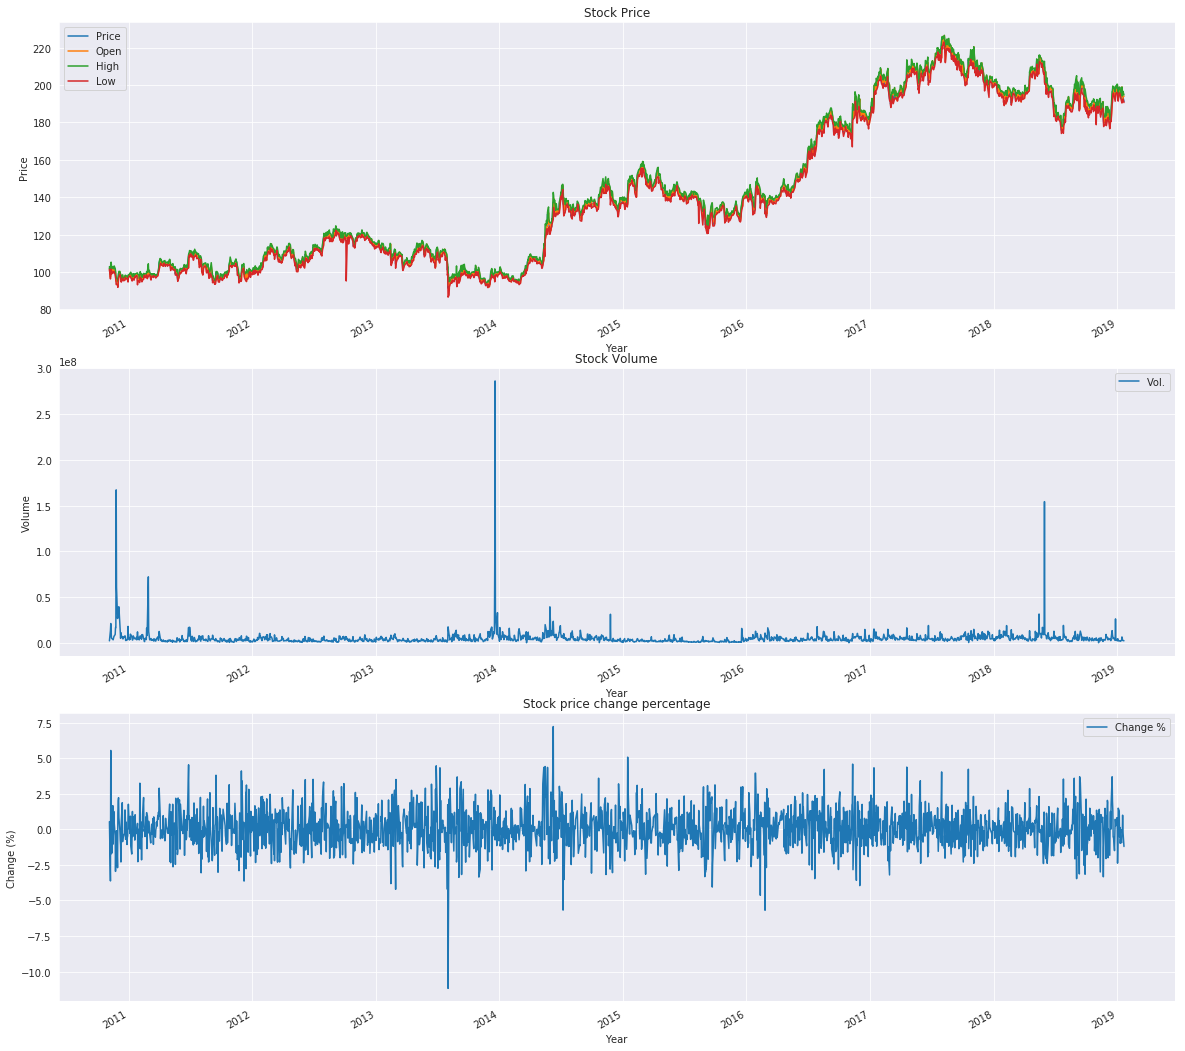

In [4]:
# initialize figure and axes
fig, (ax_1, ax_2, ax_3) = plt.subplots(3,1, figsize=(20,20))

# plot open, close, high and low prices
power_data.plot(y=['Price', 'Open', 'High', 'Low'], ax=ax_1)
ax_1.set_title('Stock Price')
ax_1.set_xlabel('Year')
ax_1.set_ylabel('Price')

# plot volume
power_data.plot(y='Vol.', ax=ax_2)
ax_2.set_title('Stock Volume')
ax_2.set_xlabel('Year')
ax_2.set_ylabel('Volume')

# plot percentage change
power_data.plot(y='Change %', ax=ax_3)
ax_3.set_title('Stock price change percentage')
ax_3.set_xlabel('Year')
ax_3.set_ylabel('Change (%)')

plt.savefig('powergrid_daily_trends.png')

In [5]:
power_data.shape

(2028, 6)

In [6]:
# split data
train_data = power_data.iloc[:1750,:]
test_data = power_data.iloc[1750:,:]

# normalize by splitting into window
window_size = 25
scaler = StandardScaler()

# normalize train data
for di in range(0, len(train_data), window_size):
    scaler.fit(train_data.iloc[di:di+window_size,:])
    train_data.iloc[di:di+window_size,:] = scaler.transform(train_data.iloc[di:di+window_size,:])

# normalize test data
test_data.iloc[:,:] = scaler.transform(test_data.iloc[:,:])

# split into train and test features and targets
X_train, y_train = train_data.iloc[:,1:], train_data.iloc[:,0]
X_test, y_test = test_data.iloc[:,1:], test_data.iloc[:,0]

In [7]:
X_train.head()

,Open,High,Low,Vol.,Change %
Date,,,,,
2010-11-05,1.251482,0.981241,1.430020,-0.634657,0.386315
2010-11-08,-0.511430,-0.269430,-0.362077,-0.290963,-1.788273
2010-11-09,0.026722,1.731644,0.405965,-0.053848,2.993735
2010-11-10,1.993761,1.820978,1.594600,-0.302635,-0.797453
2010-11-11,1.251482,1.267109,1.283726,-0.541899,-0.281184


In [8]:
X_test.head()

,Open,High,Low,Vol.,Change %
Date,,,,,
2017-12-06,-2.851084,-2.722596,-2.541706,-1.176495,0.184073
2017-12-07,-2.688553,-2.112467,-2.272884,-0.132981,1.150920
2017-12-08,-1.875900,-1.885442,-2.121672,0.525904,0.574530
2017-12-11,-1.639491,-1.431392,-1.214400,-0.674806,0.751166
2017-12-12,-1.432634,-1.686795,-1.449619,-0.661428,-0.438800


In [9]:
y_train.head()

Date
2010-11-05    1.217313
2010-11-08   -0.245994
2010-11-09    1.909417
2010-11-10    1.197538
2010-11-11    0.900922
Name: Price, dtype: float64

In [10]:
y_test.head()

Date
2017-12-06   -2.642507
2017-12-07   -1.962133
2017-12-08   -1.696621
2017-12-11   -1.298353
2017-12-12   -1.762999
Name: Price, dtype: float64

In [11]:
# initialize model with Keras
model = Sequential()

# add 3 LSTM layers with dropout
model.add(LSTM(input_dim=5, output_dim=10, return_sequences=True))
# model.add(Dropout(0.3))

model.add(LSTM(20, return_sequences=True))
# model.add(Dropout(0.5))

model.add(LSTM(50, return_sequences=False))
# model.add(Dropout(0.3))

# add Dense layer with ReLU activation
model.add(Dense(10,kernel_initializer="uniform",activation='tanh'))        

# add Dense layer with Linear activation
model.add(Dense(1,kernel_initializer="uniform",activation='linear'))

# start time
start = time.time()

# compile model
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

# model compilation time
print ('compilation time : ', time.time() - start)

compilation time :  0.04825448989868164


In [12]:
# Fit model on training data with validation data 5% of training data and 150 epochs
model.fit(X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1]),y_train, nb_epoch=350, validation_split=0.05, batch_size=50)

Train on 1662 samples, validate on 88 samples
Epoch 1/350
1662/1662 [==============================] - 4s 3ms/step - loss: 0.9979 - mean_squared_error: 0.9979 - val_loss: 1.0102 - val_mean_squared_error: 1.0102
Epoch 2/350
1662/1662 [==============================] - 1s 476us/step - loss: 0.9521 - mean_squared_error: 0.9521 - val_loss: 0.8578 - val_mean_squared_error: 0.8578
Epoch 3/350
1662/1662 [==============================] - 1s 521us/step - loss: 0.5205 - mean_squared_error: 0.5205 - val_loss: 0.2251 - val_mean_squared_error: 0.2251
Epoch 4/350
1662/1662 [==============================] - 1s 510us/step - loss: 0.1375 - mean_squared_error: 0.1375 - val_loss: 0.1218 - val_mean_squared_error: 0.1218
Epoch 5/350
1662/1662 [==============================] - 1s 526us/step - loss: 0.0972 - mean_squared_error: 0.0972 - val_loss: 0.0937 - val_mean_squared_error: 0.0937
Epoch 6/350
1662/1662 [==============================] - 1s 519us/step - loss: 0.0853 - mean_squared_error: 0.0853 - val_

1662/1662 [==============================] - 1s 494us/step - loss: 0.0466 - mean_squared_error: 0.0466 - val_loss: 0.0333 - val_mean_squared_error: 0.0333
Epoch 50/350
1662/1662 [==============================] - 1s 540us/step - loss: 0.0467 - mean_squared_error: 0.0467 - val_loss: 0.0299 - val_mean_squared_error: 0.0299
Epoch 51/350
1662/1662 [==============================] - 1s 509us/step - loss: 0.0466 - mean_squared_error: 0.0466 - val_loss: 0.0324 - val_mean_squared_error: 0.0324
Epoch 52/350
1662/1662 [==============================] - 1s 505us/step - loss: 0.0465 - mean_squared_error: 0.0465 - val_loss: 0.0304 - val_mean_squared_error: 0.0304
Epoch 53/350
1662/1662 [==============================] - 1s 481us/step - loss: 0.0463 - mean_squared_error: 0.0463 - val_loss: 0.0296 - val_mean_squared_error: 0.0296
Epoch 54/350
1662/1662 [==============================] - 1s 496us/step - loss: 0.0460 - mean_squared_error: 0.0460 - val_loss: 0.0306 - val_mean_squared_error: 0.0306
Epoch

Epoch 98/350
1662/1662 [==============================] - 1s 509us/step - loss: 0.0444 - mean_squared_error: 0.0444 - val_loss: 0.0295 - val_mean_squared_error: 0.0295
Epoch 99/350
1662/1662 [==============================] - 1s 481us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0307 - val_mean_squared_error: 0.0307
Epoch 100/350
1662/1662 [==============================] - 1s 514us/step - loss: 0.0447 - mean_squared_error: 0.0447 - val_loss: 0.0294 - val_mean_squared_error: 0.0294
Epoch 101/350
1662/1662 [==============================] - 1s 494us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0296 - val_mean_squared_error: 0.0296
Epoch 102/350
1662/1662 [==============================] - 1s 494us/step - loss: 0.0435 - mean_squared_error: 0.0435 - val_loss: 0.0304 - val_mean_squared_error: 0.0304
Epoch 103/350
1662/1662 [==============================] - 1s 518us/step - loss: 0.0442 - mean_squared_error: 0.0442 - val_loss: 0.0294 - val_mean_squared_er

1662/1662 [==============================] - 1s 474us/step - loss: 0.0430 - mean_squared_error: 0.0430 - val_loss: 0.0323 - val_mean_squared_error: 0.0323
Epoch 147/350
1662/1662 [==============================] - 1s 489us/step - loss: 0.0422 - mean_squared_error: 0.0422 - val_loss: 0.0323 - val_mean_squared_error: 0.0323
Epoch 148/350
1662/1662 [==============================] - 1s 485us/step - loss: 0.0427 - mean_squared_error: 0.0427 - val_loss: 0.0308 - val_mean_squared_error: 0.0308
Epoch 149/350
1662/1662 [==============================] - 1s 509us/step - loss: 0.0422 - mean_squared_error: 0.0422 - val_loss: 0.0312 - val_mean_squared_error: 0.0312
Epoch 150/350
1662/1662 [==============================] - 1s 511us/step - loss: 0.0433 - mean_squared_error: 0.0433 - val_loss: 0.0311 - val_mean_squared_error: 0.0311
Epoch 151/350
1662/1662 [==============================] - 1s 483us/step - loss: 0.0417 - mean_squared_error: 0.0417 - val_loss: 0.0317 - val_mean_squared_error: 0.0317


1662/1662 [==============================] - 1s 479us/step - loss: 0.0416 - mean_squared_error: 0.0416 - val_loss: 0.0307 - val_mean_squared_error: 0.0307
Epoch 195/350
1662/1662 [==============================] - 1s 514us/step - loss: 0.0416 - mean_squared_error: 0.0416 - val_loss: 0.0304 - val_mean_squared_error: 0.0304
Epoch 196/350
1662/1662 [==============================] - 1s 498us/step - loss: 0.0413 - mean_squared_error: 0.0413 - val_loss: 0.0308 - val_mean_squared_error: 0.0308
Epoch 197/350
1662/1662 [==============================] - 1s 471us/step - loss: 0.0412 - mean_squared_error: 0.0412 - val_loss: 0.0342 - val_mean_squared_error: 0.0342
Epoch 198/350
1662/1662 [==============================] - 1s 496us/step - loss: 0.0414 - mean_squared_error: 0.0414 - val_loss: 0.0316 - val_mean_squared_error: 0.0316
Epoch 199/350
1662/1662 [==============================] - 1s 502us/step - loss: 0.0413 - mean_squared_error: 0.0413 - val_loss: 0.0305 - val_mean_squared_error: 0.0305


1662/1662 [==============================] - 1s 471us/step - loss: 0.0405 - mean_squared_error: 0.0405 - val_loss: 0.0308 - val_mean_squared_error: 0.0308
Epoch 243/350
1662/1662 [==============================] - 1s 497us/step - loss: 0.0404 - mean_squared_error: 0.0404 - val_loss: 0.0307 - val_mean_squared_error: 0.0307
Epoch 244/350
1662/1662 [==============================] - 1s 454us/step - loss: 0.0404 - mean_squared_error: 0.0404 - val_loss: 0.0314 - val_mean_squared_error: 0.0314
Epoch 245/350
1662/1662 [==============================] - 1s 505us/step - loss: 0.0407 - mean_squared_error: 0.0407 - val_loss: 0.0342 - val_mean_squared_error: 0.0342
Epoch 246/350
1662/1662 [==============================] - 1s 501us/step - loss: 0.0410 - mean_squared_error: 0.0410 - val_loss: 0.0313 - val_mean_squared_error: 0.0313
Epoch 247/350
1662/1662 [==============================] - 1s 504us/step - loss: 0.0402 - mean_squared_error: 0.0402 - val_loss: 0.0318 - val_mean_squared_error: 0.0318


1662/1662 [==============================] - 1s 429us/step - loss: 0.0402 - mean_squared_error: 0.0402 - val_loss: 0.0338 - val_mean_squared_error: 0.0338
Epoch 291/350
1662/1662 [==============================] - 1s 491us/step - loss: 0.0407 - mean_squared_error: 0.0407 - val_loss: 0.0380 - val_mean_squared_error: 0.0380
Epoch 292/350
1662/1662 [==============================] - 1s 443us/step - loss: 0.0403 - mean_squared_error: 0.0403 - val_loss: 0.0330 - val_mean_squared_error: 0.0330
Epoch 293/350
1662/1662 [==============================] - 1s 529us/step - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0327 - val_mean_squared_error: 0.0327
Epoch 294/350
1662/1662 [==============================] - 1s 485us/step - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0302 - val_mean_squared_error: 0.0302
Epoch 295/350
1662/1662 [==============================] - 1s 471us/step - loss: 0.0407 - mean_squared_error: 0.0407 - val_loss: 0.0318 - val_mean_squared_error: 0.0318


1662/1662 [==============================] - 1s 461us/step - loss: 0.0393 - mean_squared_error: 0.0393 - val_loss: 0.0333 - val_mean_squared_error: 0.0333
Epoch 339/350
1662/1662 [==============================] - 1s 488us/step - loss: 0.0396 - mean_squared_error: 0.0396 - val_loss: 0.0332 - val_mean_squared_error: 0.0332
Epoch 340/350
1662/1662 [==============================] - 1s 525us/step - loss: 0.0390 - mean_squared_error: 0.0390 - val_loss: 0.0345 - val_mean_squared_error: 0.0345
Epoch 341/350
1662/1662 [==============================] - 1s 493us/step - loss: 0.0392 - mean_squared_error: 0.0392 - val_loss: 0.0325 - val_mean_squared_error: 0.0325
Epoch 342/350
1662/1662 [==============================] - 1s 498us/step - loss: 0.0392 - mean_squared_error: 0.0392 - val_loss: 0.0343 - val_mean_squared_error: 0.0343
Epoch 343/350
1662/1662 [==============================] - 1s 514us/step - loss: 0.0394 - mean_squared_error: 0.0394 - val_loss: 0.0313 - val_mean_squared_error: 0.0313


In [13]:
# make predictions
y_pred = model.predict(X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1]))

# create copy of original test data to rescale data into original format
test_predictions = test_data.copy()

# set 'Price' feature value as predicted values
test_predictions[['Price']] = y_pred

# inverse transform predictions data
test_predictions.iloc[:,:] = scaler.inverse_transform(test_predictions)
preds = test_predictions.iloc[:,0]

# inverse transform original test data
test_data.iloc[:,:] = scaler.inverse_transform(test_data)
actual = test_data.iloc[:,0]

In [14]:
preds

Date
2017-12-06    200.689201
2017-12-07    203.330982
2017-12-08    203.422239
2017-12-11    204.855367
2017-12-12    203.441251
2017-12-13    200.920107
2017-12-14    201.002453
2017-12-15    200.176944
2017-12-18    199.783913
2017-12-19    203.802870
2017-12-20    202.953821
2017-12-21    204.284091
2017-12-22    203.286820
2017-12-26    203.149657
2017-12-27    202.947231
2017-12-28    200.288564
2017-12-29    201.937034
2018-01-01    201.251035
2018-01-02    201.693908
2018-01-03    202.560817
2018-01-04    201.858620
2018-01-05    202.186593
2018-01-08    202.295428
2018-01-09    201.660241
2018-01-10    200.977647
2018-01-11    199.147755
2018-01-12    198.566918
2018-01-15    201.374213
2018-01-16    198.359534
2018-01-17    199.488463
                 ...    
2018-12-10    197.141146
2018-12-11    197.246314
2018-12-12    197.442622
2018-12-13    197.162506
2018-12-14    197.905490
2018-12-17    202.893871
2018-12-18    200.499514
2018-12-19    201.401364
2018-12-20    198.84

In [15]:
actual

Date
2017-12-06    200.25
2017-12-07    202.30
2017-12-08    203.10
2017-12-11    204.30
2017-12-12    202.90
2017-12-13    200.50
2017-12-14    200.10
2017-12-15    198.85
2017-12-18    199.90
2017-12-19    202.60
2017-12-20    202.95
2017-12-21    203.10
2017-12-22    203.05
2017-12-26    202.45
2017-12-27    201.20
2017-12-28    199.15
2017-12-29    200.35
2018-01-01    200.20
2018-01-02    200.75
2018-01-03    201.65
2018-01-04    200.35
2018-01-05    201.25
2018-01-08    200.55
2018-01-09    201.00
2018-01-10    199.85
2018-01-11    197.85
2018-01-12    196.35
2018-01-15    199.30
2018-01-16    196.20
2018-01-17    197.40
               ...  
2018-12-10    179.30
2018-12-11    180.30
2018-12-12    182.55
2018-12-13    182.55
2018-12-14    185.70
2018-12-17    192.55
2018-12-18    196.35
2018-12-19    199.00
2018-12-20    197.95
2018-12-21    196.90
2018-12-24    193.95
2018-12-26    195.30
2018-12-27    196.55
2018-12-28    197.05
2018-12-31    198.65
2019-01-01    200.00
2019-01-

In [16]:
# calculate mean squared error on test data
error = np.sqrt(mean_squared_error(preds, actual))
print(error)

7.71341814544864


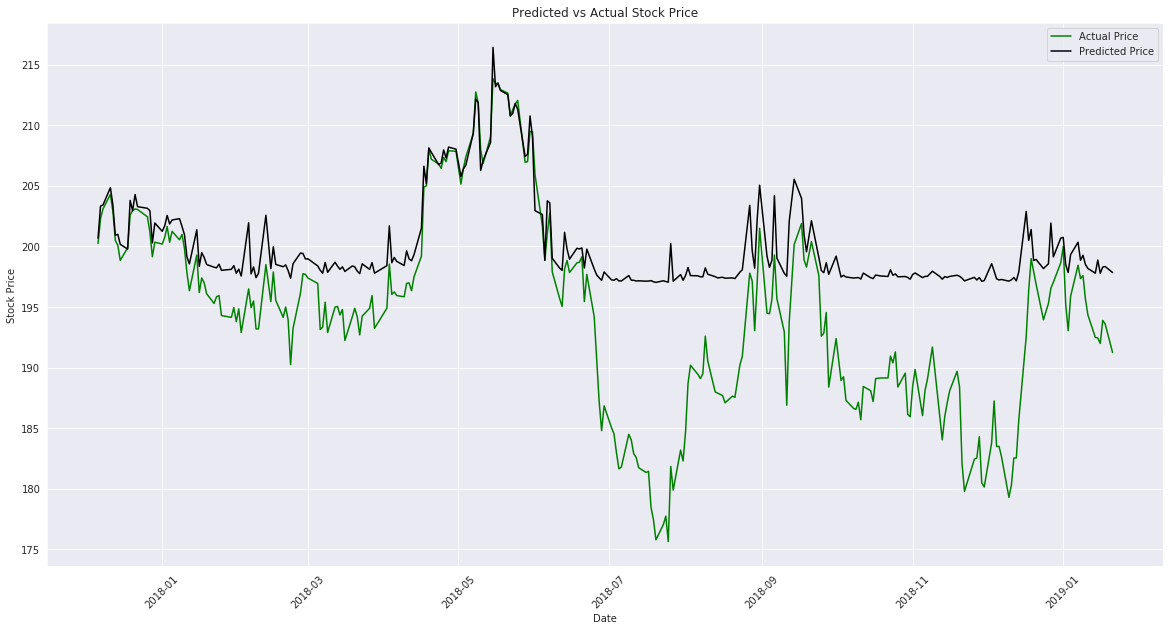

In [17]:
# comapre original vs predicted stock prices
plt.figure(figsize=(20,10))
plt.plot(actual, color='green')
plt.plot(preds, color='black')
plt.legend(['Actual Price', 'Predicted Price'])
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Predicted vs Actual Stock Price')
plt.savefig('powergrid_daily.png')

In [18]:
comp = pd.DataFrame({'Actual':actual, 'Predicted':preds}, index=actual.index)
comp.head()

,Actual,Predicted
Date,,
2017-12-06,200.25,200.689201
2017-12-07,202.30,203.330982
2017-12-08,203.10,203.422239
2017-12-11,204.30,204.855367
2017-12-12,202.90,203.441251


In [20]:
comp.to_csv('powergrid_daily.csv')